In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt
import pymc3 as pm
import seaborn as sns

from typing import List, Dict, Union
from scipy.stats import bernoulli

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
RANDOM_SEED = 242
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

This notebook demonstrates how to implement a Bayesian analysis of A/B test (also called online controlled experiments) results. We implement the models discussed in VWO's [Bayesian A/B Testing Whitepaper](https://vwo.com/downloads/VWO_SmartStats_technical_whitepaper.pdf), and briefly discuss topics like power analysis and early stopping.

#### What is A/B testing?

From https://vwo.com/ab-testing/:

> A/B testing (also known as split testing) is a process of showing two variants of the same web page to different segments of website visitors at the same time and comparing which variant drives more conversions.

We further clarify that:

* We can show more than two variants at the same time. We'll be dealing with how to analyse these tests in this notebook as well.
* Exactly what "conversions" means can vary between tests, but two classes of conversions we'll focus on are:
  * Binomial conversions - a flag for whether the visitor did the target action or not (e.g. completed at least one purchase).
  * Positive-valued conversions - a real value per visitor (e.g. the dollar revenue, which could also be 0).
  
Where does statistics and PyMC3 come into this? Our underlying assumption is that the different variants of the A/B test cause visitors to behave differently. For example, the rate at which visitors complete a purchase differs depending on the variant. We can observe visitors to collect data on this, but there will be sampling error associated with these observations, we so we need to apply statistics to quantify how confident we are that the variants actually cause different levels of behaviour. This has historically been done with traditional hypothesis testing (see [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)), but another method is to use Bayesian statistics to incorporate prior beliefs and producing a range of outcomes.

#### Synthetic data

We'll be using synthetic data for this notebook. In A/B testing, we're concerned with two types of outcomes:

* When the "true" conversion rate of each variant is the same, we don't want to incorrectly identify a "winner" (i.e. we want to minimize false positives).
* When the "true" conversion rate of each variant is different, we want to correctly identify the "winner" (i.e. we want to maximize true positives).

Our synthetic data will align with each of these scenarios.

### Binomial Metrics

In [3]:
VARIANTS = ['A', 'B', 'C']

#### Data

We first define a function to generate synthetic bernoulli conversion data. For each variant, each row will represent a visitor's conversion value (0 or 1).

In [8]:
def generate_binomial_data(variants: List[str], true_rates: List[str], samples_per_variant: int = 100000) -> pd.DataFrame:
    data = {}
    for variant, p in zip(variants, true_rates):
        data[variant] = bernoulli.rvs(p, size=samples_per_variant)
    return pd.DataFrame(data)

We generate two datasets: one where the "true" conversion rate of each variant is the same, and one where each variant has a different true rate.

In [12]:
binom_same = generate_binomial_data(VARIANTS, [0.24, 0.24, 0.24])

In [17]:
binom_same.head()

,A,B,C
0,0,0,0
1,0,0,1
2,0,1,0
3,0,0,0
4,0,0,1


In [14]:
binom_different = generate_binomial_data(VARIANTS, [0.21, 0.23, 0.235])

In [15]:
binom_different.head()

,A,B,C
0,0,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


#### Model - Simple Beta-Binomial

The model discussed in the VWO paper for binomial metrics is the Beta-Binomial model:

* The prior for the conversion rate of each variant is a Beta distribution. This takes parameters `alpha` and `beta` which together control the shape of distribution.
* The likelihood of the data is a Binomial random variable. This simply takes the number of visitors (`n`) and the number of converted visitors (`successes`) as parameters.
* We find the posterior distribution of the conversion rate for each variant, then compare the posteriors against each other to determine our confidence level for which one is the winner.

You may have noticed that we don't need PyMC3 to calculate posterior distributions in this case - Beta is a conjugate prior to the Binomial distribution, and there is a simple closed-form solution to the posterior (see the VWO paper for details). We'll still show how this can be implemented in PyMC3 for illustration purposes.

One other assumption we'll note here is that we're analysing the A/B test after it has been "completed". That is, we're reached our planned sameple size and will make a decision on the test with the aggregated available data. This is actually _not_ how most online companies run their tests in practice, and we'll discuss this further in the Early Stopping section later on.

In [21]:
from dataclasses import dataclass

In [23]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

In [24]:
@dataclass
class BinomialData:
    trials: int
    successes: int

In [34]:
class BetaBinomial:
    def __init__(self, priors: BetaPrior):
        self.priors = priors
    
    def create_model(self, data: BinomialData) -> None:
        params_shape = len(VARIANTS)
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=params_shape)
            obs = pm.Binomial("y", n=data.trials, p=p, shape=params_shape, observed=data.successes)
        self.model = model
    
    def sample(self, raw_data: pd.DataFrame) -> az.InferenceData:
        agg = raw_data.aggregate(['sum', 'count'])
        data = BinomialData(trials=agg.loc['count'].values, successes=agg.loc['sum'].values)
        self.create_model(data)
        with self.model:
            samples = pm.sample(5000, tune=1000, return_inferencedata=True)
        return samples

Now that we've defined a class that can take a prior and our synthetic data as inputs, our first step is to choose an appropriate prior. There are a few things to consider when doing this in practice, but for the purpose of this notebook we'll focus on the following things:

* We assume that the same Beta prior is set for all variants.
* An _uninformative_ or _weakly informative_ prior occurs when we set low values for `alpha` and `beta`. For example, `alpha = 1, beta = 1` leads to a uniform distribution as a prior. Normally, if we're considering one distribution isolation, setting this prior is a statement that we're not confident about its location and shape. In the context of A/B testing however, we're interested in comparing the posterior distributions of each variant to other variants. If we perform a prior predictive check on this quantity, we'll find that the range of outcomes for the uplift distributions (e.g. the relative uplift of variant B over variant A, `B / A - 1`) is very wide. This means we're implicitly saying that the variants could be very different to each other.
* A strong prior occurs when we set high values for `alpha` and `beta`. Contrary to the point above, setting this prior for each variant would imply that the relative uplift distributions between the variants are thin, i.e. our prior belief is that the variants are not very different from each other.

We illustrate the prior predictive checks below.

#### Prior predictive checks

In [57]:
binom_weak = BetaBinomial(priors=BetaPrior(alpha=100, beta=100))

In [58]:
binom_strong = BetaBinomial(priors=BetaPrior(alpha=50000, beta=50000))

For a prior predictive check, we pass in minimal oserved data:

In [59]:
minimal_df = pd.DataFrame({'A': [0], 'B': [0], 'C': [0]}, index=[0])

In [60]:
prior_pred_weak = binom_weak.sample(minimal_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.


In [61]:
prior_pred_strong = binom_strong.sample(minimal_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.


The quantity we're interested in here is the _relative uplift_ between the variants (remember that our objective from A/B testing is to determine whether there is a winning variant). We have three variants, but for illustrating how the model and priors work we'll focus on the first two variants. To get the uplift of B over A, we simple take `B / A - 1` for each sample in the posterior distribution.

In [62]:
def rel_uplift(samples):
    return samples.posterior['p'][:, :, 1] / samples.posterior['p'][:, :, 0] - 1

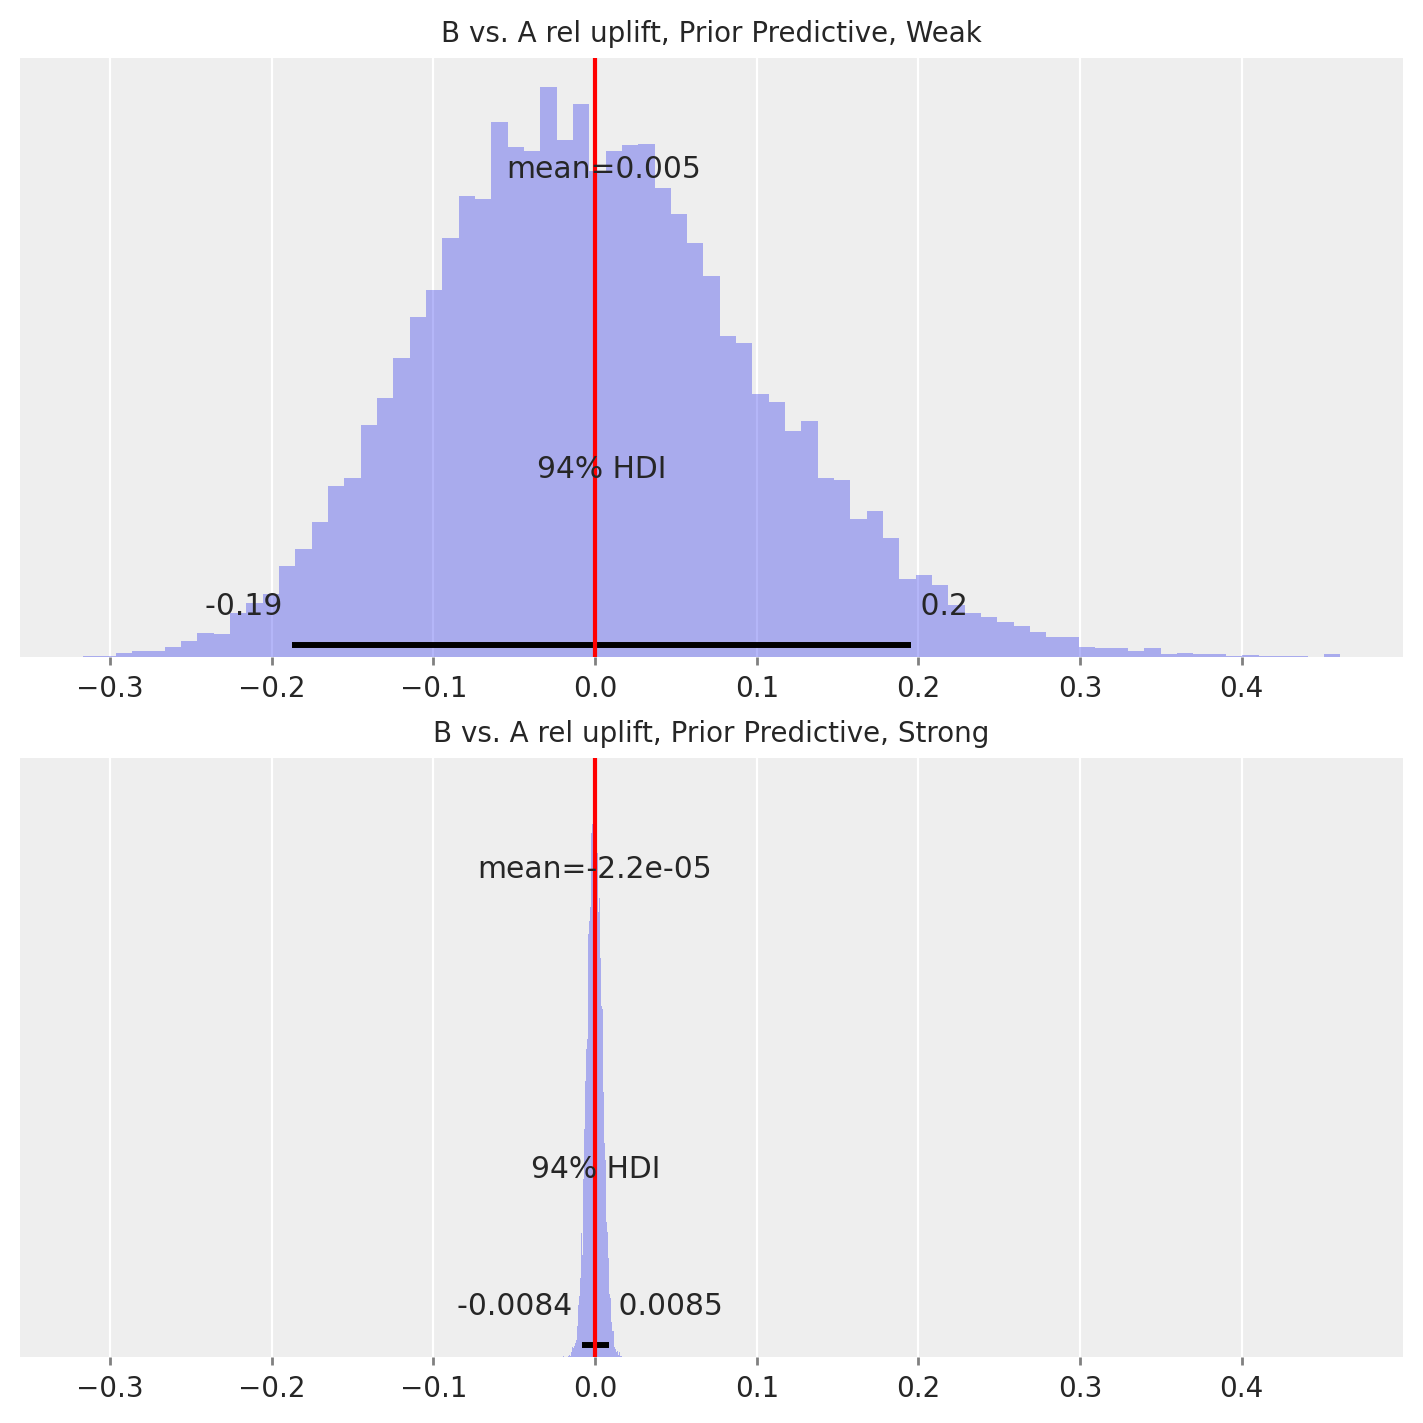

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
az.plot_posterior(rel_uplift(prior_pred_weak), textsize=10, ax=axs[0], kind='hist')
axs[0].set_title('B vs. A rel uplift, Prior Predictive, Weak', fontsize=10)
axs[0].axvline(x=0, color='red')
az.plot_posterior(rel_uplift(prior_pred_strong), textsize=10, ax=axs[1], kind='hist')
axs[1].set_title('B vs. A rel uplift, Prior Predictive, Strong', fontsize=10)
axs[1].axvline(x=0, color='red')

We can see how the choice of the prior affects our final inference. With the weak prior our 94% HDI for the relative uplift for B over A is [-19%, 20%], whereas it is [-0.85%, 0.85%] with the strong prior.

How we choose these priors in practice depends on broader context of the company running the A/B tests. A strong prior can help guard against false discoveries, but may require much more data for us to detect winning variants when they exist (and more data = more time required running the test). Below we'll walk through the inference results from two different prior choices.

#### Scenario 1 - same underlying conversion rates

In [69]:
samples = {
    'weak_same': binom_weak.sample(raw_data=binom_same),
    'strong_same': binom_strong.sample(raw_data=binom_same)
}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.


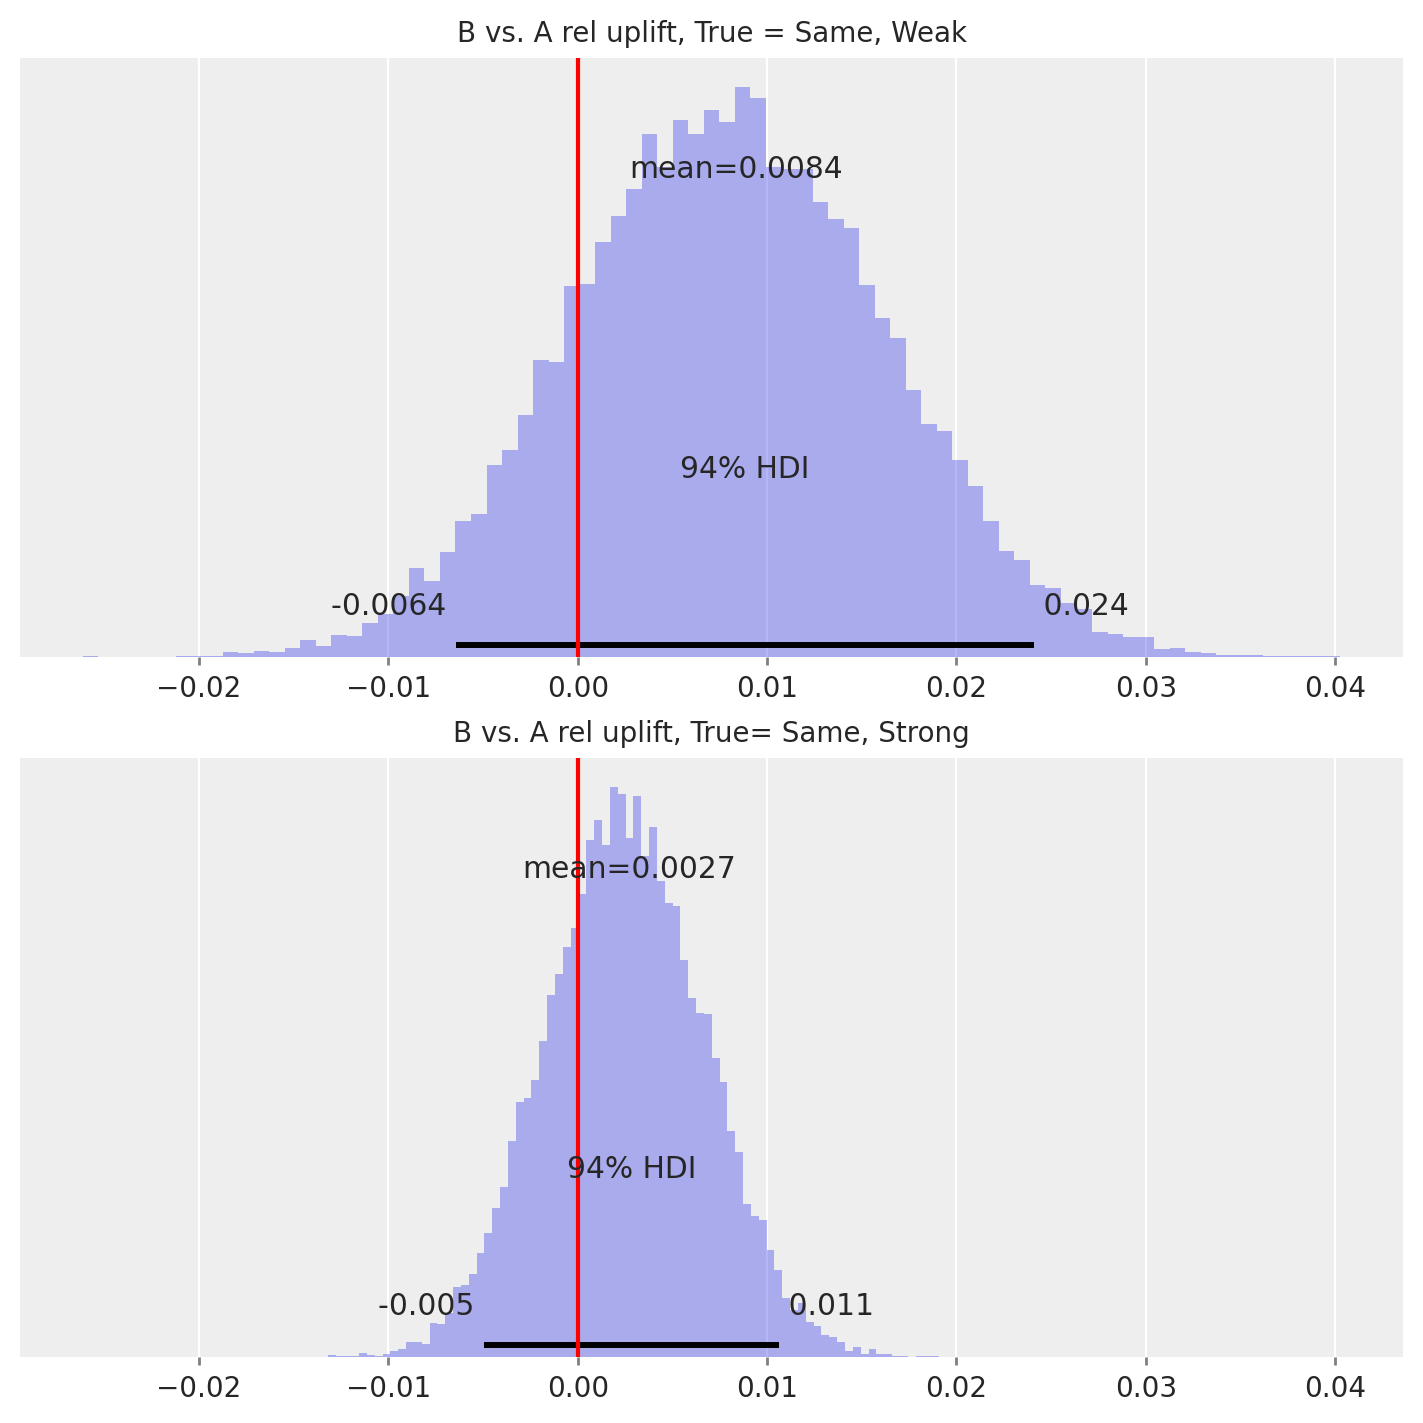

In [70]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
az.plot_posterior(rel_uplift(samples['weak_same']), textsize=10, ax=axs[0], kind='hist')
axs[0].set_title('B vs. A rel uplift, True = Same, Weak', fontsize=10)
axs[0].axvline(x=0, color='red')
az.plot_posterior(rel_uplift(samples['strong_same']), textsize=10, ax=axs[1], kind='hist')
axs[1].set_title('B vs. A rel uplift, True= Same, Strong', fontsize=10)
axs[1].axvline(x=0, color='red')

* In both cases, the true rate of 0 lies within the 94% HDI.

#### Scenario 2 - different underlying rates

In [74]:
samples = {
    'weak_different': binom_weak.sample(raw_data=binom_different),
    'strong_different': binom_strong.sample(raw_data=binom_different)
}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 14 seconds.


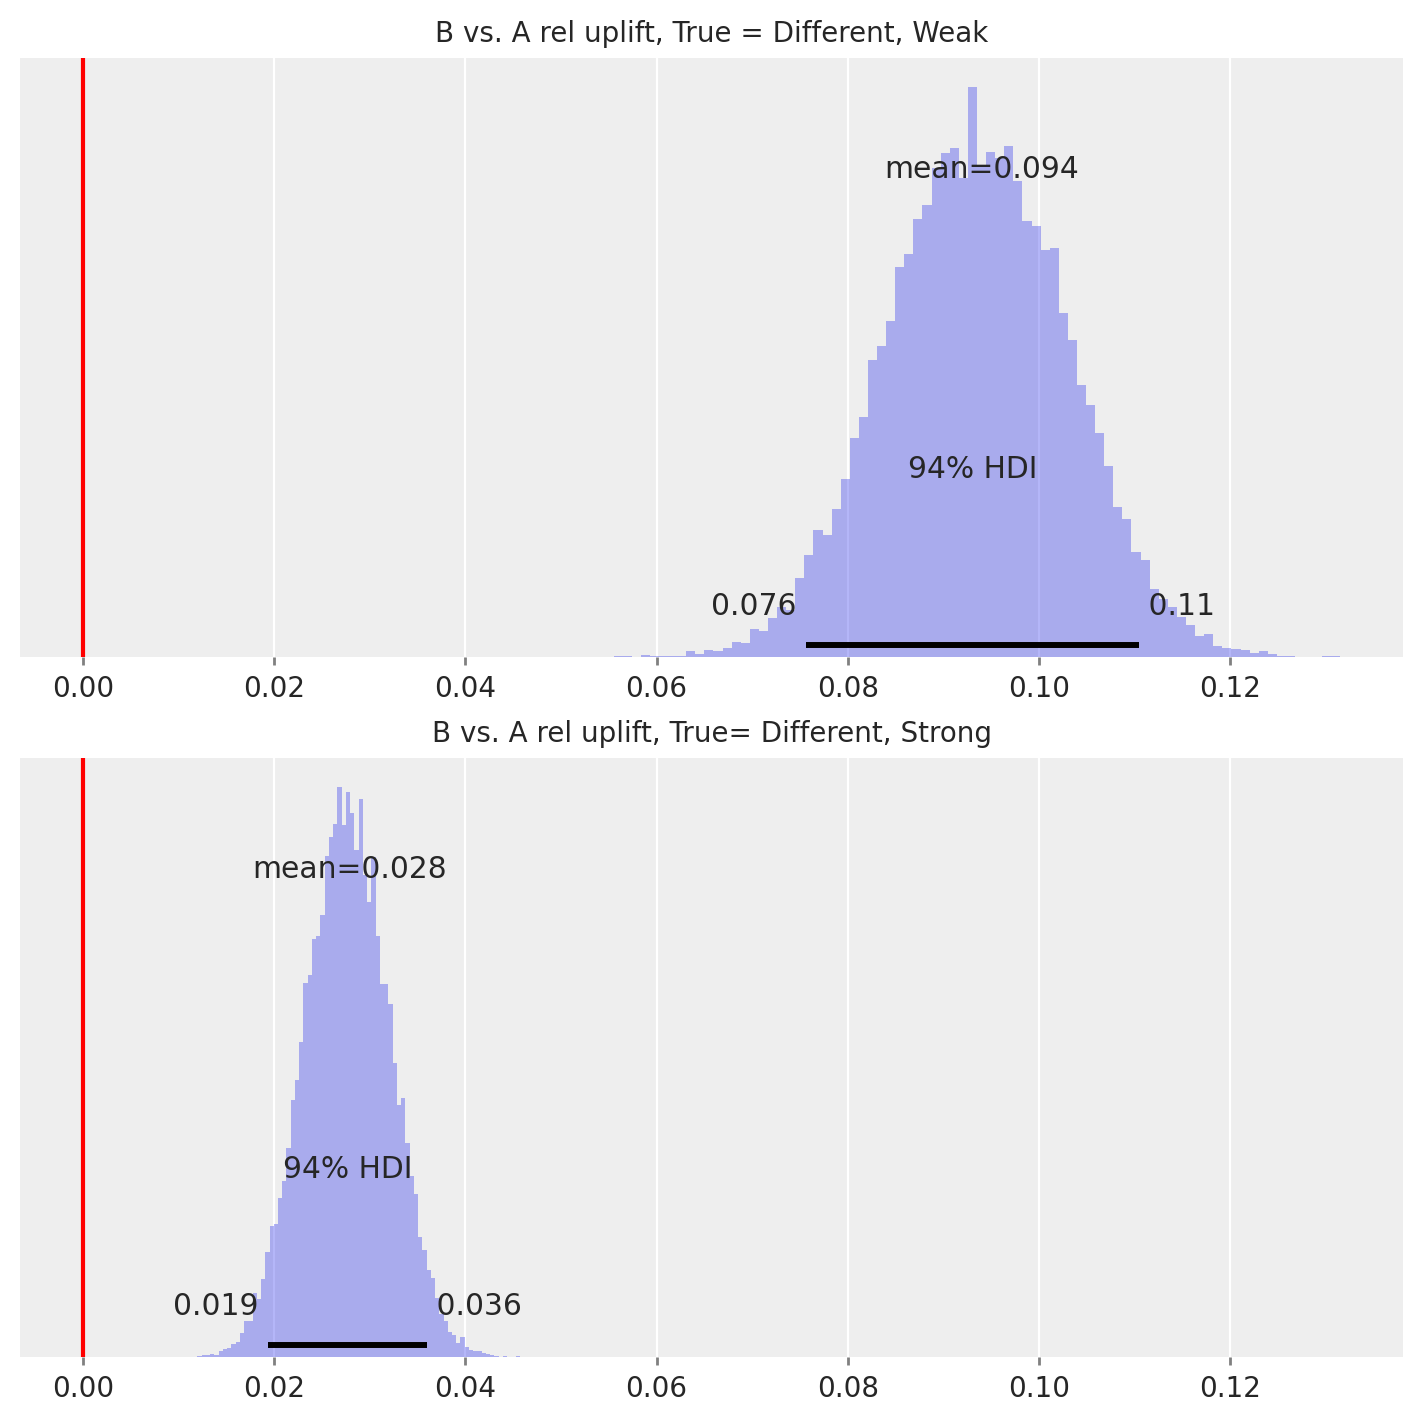

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
az.plot_posterior(rel_uplift(samples['weak_different']), textsize=10, ax=axs[0], kind='hist')
axs[0].set_title('B vs. A rel uplift, True = Different, Weak', fontsize=10)
axs[0].axvline(x=0, color='red')
az.plot_posterior(rel_uplift(samples['strong_different']), textsize=10, ax=axs[1], kind='hist')
axs[1].set_title('B vs. A rel uplift, True= Different, Strong', fontsize=10)
axs[1].axvline(x=0, color='red')

* In both cases, the posterior relative uplift distribution suggests that B has a higher conversion rate than A (a true discovery).
* However, the weak prior centers the uplift distribution around 9.4%, whereas the strong prior centers it around 2.8%
* If we compare the actual changes, we set p_B = 0.23 and p_A = 0.21, which is a relative difference of 9.5%.
* In this case, the effect of the prior outweighs the effect of the observed data, so our central estimate of the relative difference is conservative (and understated). We would need much more data for our inference to get closer to the true difference of 9.5%.

The above examples demonstrate how to calculate relative uplift distributions with the Beta Binomial model, and the benefits and disadvantages of choosing a weak vs. strong prior. We will go deeper into Power Analysis and Early Stopping later, where the prior chosen will also have an effect.